# Lontoon Airbnb asuntojen tärkeimmät muuttujat hinnan kannalta

### Analyysin tarkoitus
* Tarkoituksena on tarjota Lontoon airbnb asunnon vuokranantajalle avaimet hinnan määrittämiseen. 
* Analyysiä voidaan käyttää hyödyksi jo olemassa oleviin asuntoihin tai tukena uuden asunnon ostossa.
* Analyysi on tehty yhden, kahden ja yli kahden makuuhuoneen asunnoille erikseen, koska niiden hintaa vaikuttavat eri tekijät.


#### Aluksi otetaan tarvittavat kirjastot käyttöön.

In [62]:
!pip install sklearn
import pandas as pd
import numpy as np
from sklearn import ensemble
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from collections import Counter

#### Katsotaan, mitä sarakkeita datasta löytyy.

In [63]:
LONDON = 'listings.csv.gz'
df = pd.read_csv(LONDON, low_memory=False)
print('Sarakkeet:', df.columns.values.tolist())

Sarakkeet: ['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'price', 'weekly_price', 'monthl

#### Valitaan analyysin kannalta oleellisimmat sarakkeet.

In [64]:
sarakkeet = ['price',
        'accommodates',
        'bedrooms',
        'beds',
        'room_type',
        'minimum_nights',
        'latitude',
        'longitude',
        'reviews_per_month',
        'number_of_reviews',
        'availability_30',
        'review_scores_rating'
        ]
df = pd.read_csv(LONDON, usecols=sarakkeet)
df

,latitude,longitude,room_type,accommodates,bedrooms,beds,price,minimum_nights,availability_30,number_of_reviews,review_scores_rating,reviews_per_month
0,51.56802,-0.11121,Private room,2,1.0,0.0,$65.00,1,23,21,97.0,0.18
1,51.48796,-0.16898,Entire home/apt,2,1.0,1.0,$100.00,10,6,88,96.0,0.71
2,51.52195,-0.14094,Entire home/apt,6,3.0,3.0,$300.00,3,26,42,94.0,0.38
3,51.47935,-0.19743,Private room,2,1.0,1.0,$150.00,3,29,0,NaN,NaN
4,51.44687,-0.21874,Entire home/apt,4,2.0,2.0,$65.00,21,7,34,93.0,0.69
...,...,...,...,...,...,...,...,...,...,...,...,...
88124,51.65118,-0.19511,Private room,3,3.0,3.0,$40.00,1,23,0,NaN,NaN
88125,51.48843,0.05332,Entire home/apt,6,0.0,3.0,$86.00,2,23,0,NaN,NaN
88126,51.53211,-0.21826,Private room,4,1.0,0.0,$65.00,1,23,0,NaN,NaN
88127,51.55715,-0.06898,Entire home/apt,4,1.0,1.0,$100.00,21,0,0,NaN,NaN


#### Tarkistetaan haluttujen sarakkeiden datatyyppit

In [65]:
df.dtypes

latitude                float64
longitude               float64
room_type                object
accommodates              int64
bedrooms                float64
beds                    float64
price                    object
minimum_nights            int64
availability_30           int64
number_of_reviews         int64
review_scores_rating    float64
reviews_per_month       float64
dtype: object

* Huomataan, että "price" eli hinta on object-tyyppiä sekä sieltä löytyy dollarin merkkejä. Näin ollen halutaan poistaa merkit sekä muuttaa hinnan datatyyppiä.

In [66]:
df['price'] = df['price'].replace('[\$,)]','', regex=True).replace('[(]','-', regex=True).astype(float)
print(df.price.head(5))

0     65.0
1    100.0
2    300.0
3    150.0
4     65.0
Name: price, dtype: float64


* Poistetaan kaikki rivit, joissa on NaN arvoja. Näin saadaan n. 30000 riviä poistettua.

In [67]:
df = df[df.bedrooms != 0]
df = df[df.beds != 0]
df = df[df.price != 0]

# Tämä tehdään, koska niitä ei ole, jos number_of_reviews on 0
df['reviews_per_month'].fillna(0, inplace=True)
df = df.dropna(axis=0)
df.shape

(59173, 12)

#### Seuraavaksi teemme kategorisista muuttujista dummies muuttujia, jotta niiden analysoiminen onnistuu paremmin.
* Valituista muuttujista ainoataan room_type on sellainen, jonka muuttaminen on järkevää

In [68]:
rt_dummies = pd.get_dummies(df.room_type)

alldata = pd.concat((df.drop(['room_type'], axis=1), rt_dummies.astype(int)), axis=1)
alldata.head(5)

,latitude,longitude,accommodates,bedrooms,beds,price,minimum_nights,availability_30,number_of_reviews,review_scores_rating,reviews_per_month,Entire home/apt,Hotel room,Private room,Shared room
1,51.48796,-0.16898,2,1.0,1.0,100.0,10,6,88,96.0,0.71,1,0,0,0
2,51.52195,-0.14094,6,3.0,3.0,300.0,3,26,42,94.0,0.38,1,0,0,0
4,51.44687,-0.21874,4,2.0,2.0,65.0,21,7,34,93.0,0.69,1,0,0,0
6,51.46507,-0.32421,2,1.0,1.0,100.0,1,29,6,90.0,0.05,0,0,1,0
7,51.47934,-0.28066,5,3.0,3.0,195.0,3,6,77,97.0,0.67,1,0,0,0


#### Seuraavaksi lisäämme dataan uuden sarakkeen eli etäisyys lontoon keskustasta. Tällä tavalla rikastetaan dataa
* Tämä myös järkevöittää leveys- ja piituuspiirien vertailua eli asunnon sijainnin vertailua Lontoon alueella

In [69]:
etäisyys_lista = []
for i in range(len(alldata)):
    latitude_london = 51.507222
    longitude_london = -0.1275
    etäisyys = np.sqrt(np.square(alldata.latitude.iloc[i] - latitude_london) + 
                  np.square(alldata.longitude.iloc[i] - longitude_london))
    etäisyys_lista.append(etäisyys)

alldata['distance_to_center'] = etäisyys_lista


In [70]:
alldata.head(5)

,latitude,longitude,accommodates,bedrooms,beds,price,minimum_nights,availability_30,number_of_reviews,review_scores_rating,reviews_per_month,Entire home/apt,Hotel room,Private room,Shared room,distance_to_center
1,51.48796,-0.16898,2,1.0,1.0,100.0,10,6,88,96.0,0.71,1,0,0,0,0.045734
2,51.52195,-0.14094,6,3.0,3.0,300.0,3,26,42,94.0,0.38,1,0,0,0,0.019939
4,51.44687,-0.21874,4,2.0,2.0,65.0,21,7,34,93.0,0.69,1,0,0,0,0.109394
6,51.46507,-0.32421,2,1.0,1.0,100.0,1,29,6,90.0,0.05,0,0,1,0,0.201176
7,51.47934,-0.28066,5,3.0,3.0,195.0,3,6,77,97.0,0.67,1,0,0,0,0.155677


#### Seuraavaksi otamme käsittelyyn Starbuck ravintoloiden sijainnit ja rikastamme dataa silläkin. 
* Tarkoituksena on saada selville, että onko Starbuckin läheisyydellä merkitystä hinnan muodostumisen kannalta

In [71]:
STARBUCKS = 'starbuck.csv'
starbucks_df = pd.read_csv(STARBUCKS)
starbucks_df.head()

,Brand,Store Number,Store Name,Ownership Type,Street Address,City,State/Province,Country,Postcode,Phone Number,Timezone,Longitude,Latitude
0,Starbucks,47370-257954,"Meritxell, 96",Licensed,"Av. Meritxell, 96",Andorra la Vella,7,AD,AD500,376818720,GMT+1:00 Europe/Andorra,1.53,42.51
1,Starbucks,22331-212325,Ajman Drive Thru,Licensed,"1 Street 69, Al Jarf",Ajman,AJ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,55.47,25.42
2,Starbucks,47089-256771,Dana Mall,Licensed,Sheikh Khalifa Bin Zayed St.,Ajman,AJ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,55.47,25.39
3,Starbucks,22126-218024,Twofour 54,Licensed,Al Salam Street,Abu Dhabi,AZ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,54.38,24.48
4,Starbucks,17127-178586,Al Ain Tower,Licensed,"Khaldiya Area, Abu Dhabi Island",Abu Dhabi,AZ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,54.54,24.51


#### Datasta täytyy siivota ja järjestellä eli poistetaan tyhjät ja otetaan ainoastaan Britannian Lontoon tiedot

In [72]:
starbucks_df = starbucks_df[starbucks_df.City == 'London']
starbucks_df = starbucks_df[starbucks_df.Country == 'GB']
starbucks_df.head(5)

,Brand,Store Number,Store Name,Ownership Type,Street Address,City,State/Province,Country,Postcode,Phone Number,Timezone,Longitude,Latitude
5642,Starbucks,12929-137795,Clapham - St. John's Road,Company Owned,"37-39 St. John's Road, Brixton Underground Sta...",London,ENG,GB,SW11 1QN,2079244670,GMT+0:00 Europe/London,-0.17,51.46
5643,Starbucks,7013-150064,Brixton Station,Company Owned,"Shop 5, Brixton Underground Station",London,ENG,GB,SW9,2072747979,GMT+0:00 Europe/London,-0.11,51.46
5644,Starbucks,14945-154366,Stansted Airport DT,Franchise,"A120 Thermal Lane, London Stansted Airport",London,ENG,GB,CM24 1PY,01279 680361,GMT+0:00 Europe/London,0.25,51.88
5645,Starbucks,12949-140506,Juxon House - St. Pauls Church Yard,Company Owned,"St. Paul's Church Yard, Juxon House, Unit 2, R...",London,ENG,GB,EC4M 8EH,2072480359,GMT+0:00 Europe/London,-0.10,51.51
5646,Starbucks,12600-98209,Pentonville Road,Company Owned,"296 Pentoville Road, Regents Corner, London - ...",London,ENG,GB,N1 9NR,2078121073,GMT+0:00 Europe/London,-0.12,51.53


In [73]:
starbucks_df.shape

(195, 13)

* Otetaan ainoastaa tarvittavat tiedot eli latitude ja longitude, koska haluamme tietää, että onko asunnon ja lähimmän starbucksin etäisyydellä merkitystä.

In [74]:
starbucks_df = starbucks_df[['Latitude', 'Longitude']]
starbucks_df.head(5)

,Latitude,Longitude
5642,51.46,-0.17
5643,51.46,-0.11
5644,51.88,0.25
5645,51.51,-0.10
5646,51.53,-0.12


* Tarkistetaan, että onko tyhjiä arvoja
* Lisäksi tarkistetaan arvojen järkevyys

In [75]:
starbucks_df.describe()

,Latitude,Longitude
count,195.000000,195.000000
mean,51.534410,-0.150308
std,0.306064,0.206512
min,51.410000,-2.870000
25%,51.500000,-0.180000
50%,51.510000,-0.140000
75%,51.520000,-0.100000
max,55.740000,0.250000


* Koska omituisia maksimi- ja minimiarvoja sekä tyhjiä arvoja ei ole, voidaan alkaa laskea etäisyyksiä. Etäisyyksien laskeminen kestää suhteellisen pitkään, sillä jokaiselle 59185 asunnon ja 195 kahvilan etäisyys toisistaan pitää tarkistaa.
  Näin laskutoimituksia syntyy 59185 * 195 verran

In [76]:
etäisyys_lista = []
for i in range(len(alldata)):
    lyhin_etäisyys = 1
    latitude = alldata.latitude.iloc[i]
    longitude = alldata.longitude.iloc[i]
    for j in range(len(starbucks_df)):
        if (j == 0):
            lyhin_etäisyys = np.sqrt(np.square(latitude - starbucks_df.Latitude.iloc[j]) + 
                  np.square(longitude - starbucks_df.Longitude.iloc[j]))
        else:
            etäisyys = np.sqrt(np.square(latitude - starbucks_df.Latitude.iloc[j]) + 
                  np.square(longitude - starbucks_df.Longitude.iloc[j]))
            if (etäisyys < lyhin_etäisyys):
                lyhin_etäisyys = etäisyys
    etäisyys_lista.append(lyhin_etäisyys)
    
alldata['distance_to_starbuck'] = etäisyys_lista

In [77]:
alldata.head(5)

,latitude,longitude,accommodates,bedrooms,beds,price,minimum_nights,availability_30,number_of_reviews,review_scores_rating,reviews_per_month,Entire home/apt,Hotel room,Private room,Shared room,distance_to_center,distance_to_starbuck
1,51.48796,-0.16898,2,1.0,1.0,100.0,10,6,88,96.0,0.71,1,0,0,0,0.045734,0.002281
2,51.52195,-0.14094,6,3.0,3.0,300.0,3,26,42,94.0,0.38,1,0,0,0,0.019939,0.002165
4,51.44687,-0.21874,4,2.0,2.0,65.0,21,7,34,93.0,0.69,1,0,0,0,0.109394,0.011117
6,51.46507,-0.32421,2,1.0,1.0,100.0,1,29,6,90.0,0.05,0,0,1,0,0.201176,0.037326
7,51.47934,-0.28066,5,3.0,3.0,195.0,3,6,77,97.0,0.67,1,0,0,0,0.155677,0.009363


#### Nyt kun dataa siivottu ja rikastettu voidaan poistaa turhat sarakkeet eli latitude ja longitude

In [78]:
alldata = alldata.drop(['latitude', 'longitude'], axis=1)

* Tämän jälkeen hieman visualisoidaan dataa eli katsotaan muuttujien määriä

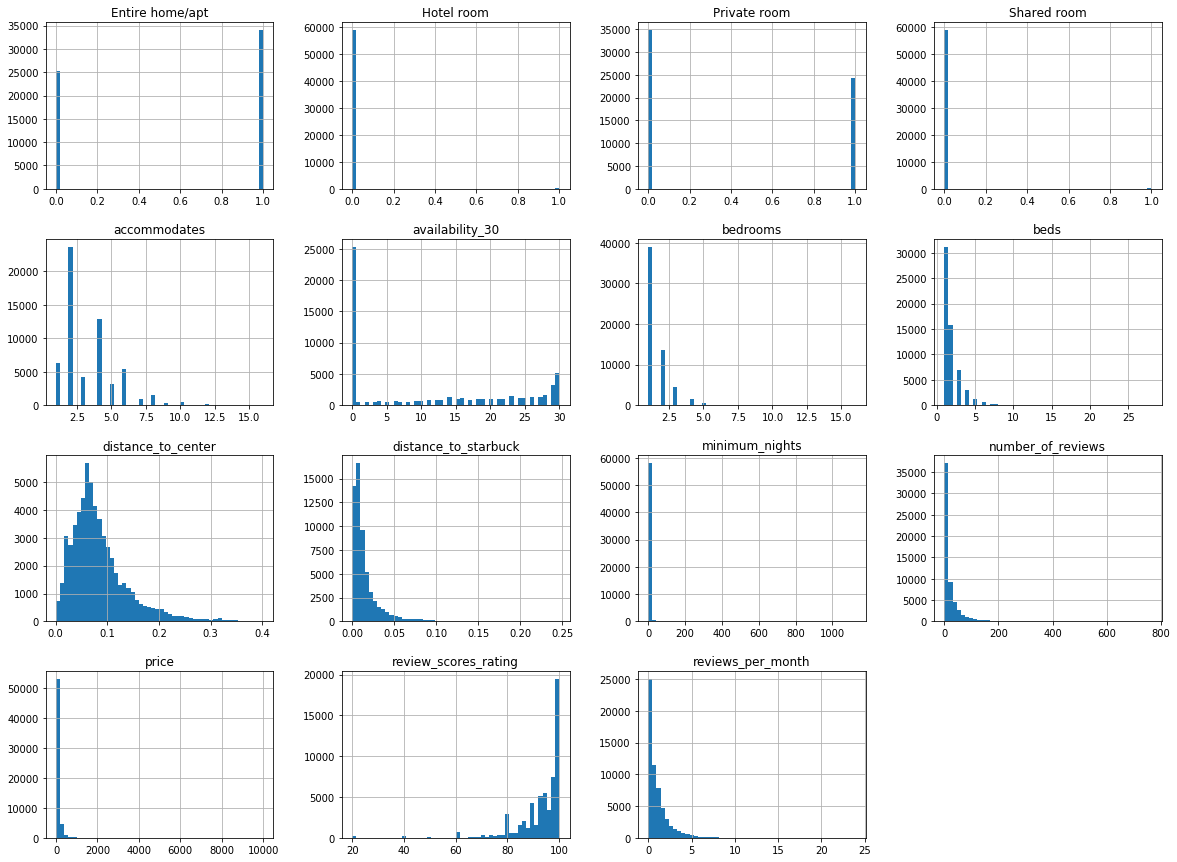

In [79]:
alldata.hist(bins=50, figsize=(20,15))
plt.show()

* Kuvaajista huomataan, että hotellihuoneita ja jaettuja huoneita on hyvin vähän kaikista asunnoista. 

### Analyysin vuoro
* Tehdään analyysit erikseen yhden ja kahden huoneen airbnb kämpille ja yli kahden huoneen kämpille, joten tarkistetaan aluksi, että niiden määrä on sopiva

In [80]:
len(alldata[alldata.bedrooms == 1])

39063

In [81]:
len(alldata[alldata.bedrooms == 2])

13694

In [82]:
len(alldata[alldata.bedrooms > 2])

6416

* Sitten teemme monimuuttujaregression, jonka avulla saadaan tärkeimmät muuttujat hinnan kannalta ja virhettä laskelmille

13.102878912040648


Text(0.5, 1.0, 'Variable Importance')

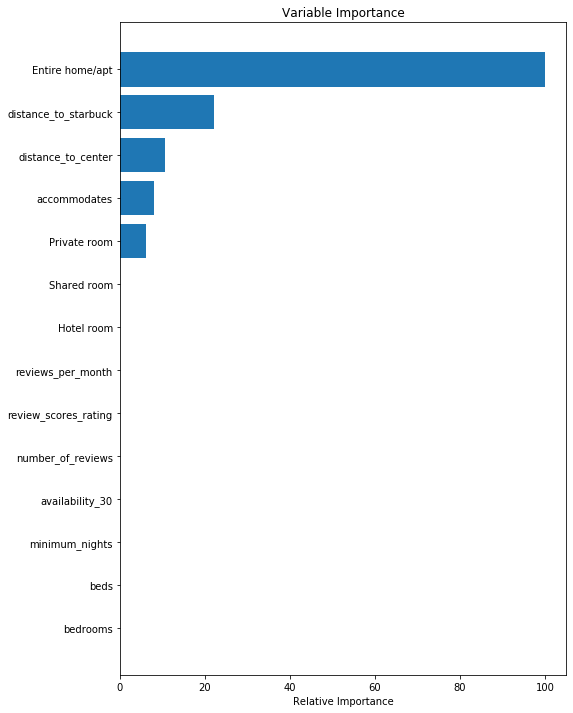

In [83]:
One_bedroom_df = alldata[alldata.bedrooms == 1]

X_train, X_test, y_train, y_test = train_test_split(One_bedroom_df.drop(['price'], axis=1),
                                                    One_bedroom_df.price, test_size=0.2, random_state=20)

n_est = 300
tuned_parameters = {
    "n_estimators": [ n_est ],
    "max_depth" : [ 4 ],
    "learning_rate": [ 0.01 ],
    "min_samples_split" : [ 1.0 ],
    "loss" : [ 'ls', 'lad' ]
}

gbr = ensemble.GradientBoostingRegressor()
clf = GridSearchCV(gbr, cv=3, param_grid=tuned_parameters,
        scoring='neg_median_absolute_error')
preds = clf.fit(X_train, y_train)
print(abs(clf.best_score_))

feature_importance = clf.best_estimator_.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
pvals = feature_importance[sorted_idx]
pcols = X_train.columns[sorted_idx]
plt.figure(figsize=(8,12))
plt.barh(pos, pvals, align='center')
plt.yticks(pos, pcols)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')

* Huomataan, että yhden makuuhuoneen asunnoissa hinnan kannalta tärkeimmät muuttujat ovat koko asunto, etäisyys Starbucksista, etäisyys keskustasta, majoitettavien määrä ja yksityishuone. Analyysin mediaani virhe on 13,10 $

32.88470349593331


Text(0.5, 1.0, 'Variable Importance')

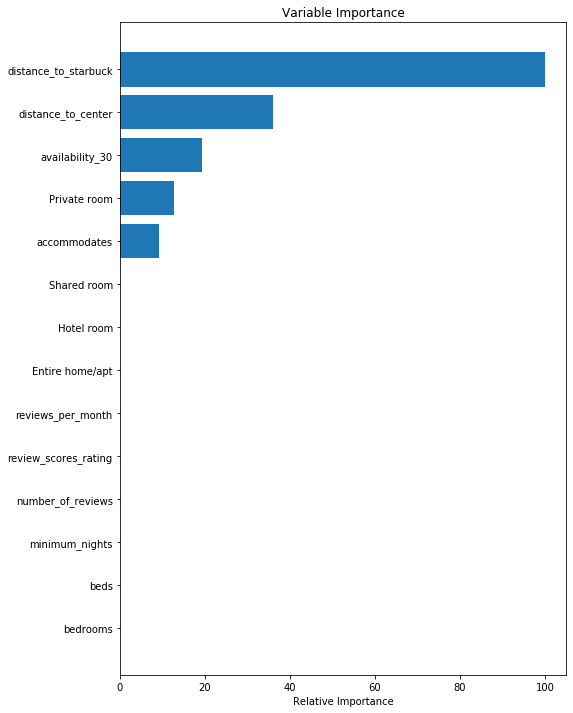

In [84]:
Two_bedroom_df = alldata[alldata.bedrooms == 2]

X_train, X_test, y_train, y_test = train_test_split(Two_bedroom_df.drop(['price'], axis=1),
                                                    Two_bedroom_df.price, test_size=0.2, random_state=20)

n_est = 300
tuned_parameters = {
    "n_estimators": [ n_est ],
    "max_depth" : [ 4 ],
    "learning_rate": [ 0.01 ],
    "min_samples_split" : [ 1.0 ],
    "loss" : [ 'ls', 'lad' ]
}

gbr = ensemble.GradientBoostingRegressor()
clf = GridSearchCV(gbr, cv=3, param_grid=tuned_parameters,
        scoring='neg_median_absolute_error')
preds = clf.fit(X_train, y_train)
print(abs(clf.best_score_))

feature_importance = clf.best_estimator_.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
pvals = feature_importance[sorted_idx]
pcols = X_train.columns[sorted_idx]
plt.figure(figsize=(8,12))
plt.barh(pos, pvals, align='center')
plt.yticks(pos, pcols)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')

* Huomataan, että kahden makuuhuoneen asunnoissa hinnan kannalta tärkeimmät muuttujat ovat etäisyys Starbuckista, etäisyys keskustasta, 30 päivän saatavuus, yksityishuone ja majoitettavien määrä. Analyysin mediaani virhe on 32,88 $

59.02234786368056


Text(0.5, 1.0, 'Variable Importance')

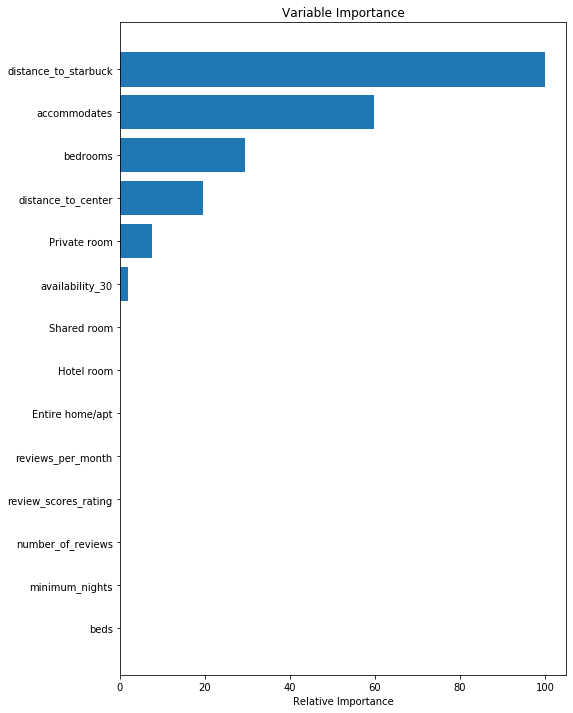

In [85]:
Over_two_bedroom_df = alldata[alldata.bedrooms > 2]

X_train, X_test, y_train, y_test = train_test_split(Over_two_bedroom_df.drop(['price'], axis=1),
                                                    Over_two_bedroom_df.price, test_size=0.2, random_state=20)

n_est = 300
tuned_parameters = {
    "n_estimators": [ n_est ],
    "max_depth" : [ 4 ],
    "learning_rate": [ 0.01 ],
    "min_samples_split" : [ 1.0 ],
    "loss" : [ 'ls', 'lad' ]
}

gbr = ensemble.GradientBoostingRegressor()
clf = GridSearchCV(gbr, cv=3, param_grid=tuned_parameters,
        scoring='neg_median_absolute_error')
preds = clf.fit(X_train, y_train)
print(abs(clf.best_score_))

feature_importance = clf.best_estimator_.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
pvals = feature_importance[sorted_idx]
pcols = X_train.columns[sorted_idx]
plt.figure(figsize=(8,12))
plt.barh(pos, pvals, align='center')
plt.yticks(pos, pcols)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')

* Huomataan, että yli kahden makuuhuoneen asunnoissa hinnan kannalta tärkeimmät muuttujat ovat etäisyys Starbucksista, majoitettavien määrä, sänkyjen määrä, etäisyys keskustasta, yksityishuone ja 30 päivän saatavuus. Analyysin mediaani virhe on 59,02 $

## Lopputulos

* Eri muuttujat vaikuttavat hintaan eniten, kun makuuhuoneiden määrää vaihdetaan
* Analyysi on tarkin yhden makuuhuoneen asunnoissa, joka johtuu todennäköisesti siitä, että niitä on lukumäärällisesti eniten
* Tätä analyysiä voi Lontoon vuokranantaja hyödyntää olemassa olevan asunnon hinnna määrittämisessä tai uuden asunnon ostossa, kun mietitään vuokrapotentiaalia

#### Tekijä
* Saku Laitinen, saku.laitinen@tuni.fi